# Project 4: Football matches as mobility networks
During a football match, players move on the field to attack and defend. This generates a series of movements that can be analyzed to understand the players behavior.<br><br>
The student should use the `Wyscout open dataset`, describing the “events” in all matches of seven competitions (e.g., passes, shots, tackles etc.), to analyze pass chains and the mobility of football players. A player’s movement is defined by consecutive events made by that player in the match.<br><br>
- Investigate the distances traveled by players during their matches and their distributions. Discuss about the similarity of these distributions with those about mobility trajectories seen during the course.<br><br>
- Relate the pass chains made by teams with the probability of making a shot, a goal, and to win a match. Are long chains more likely to lead to a shot/goal? Are short pass chains more successful?<br><br>
- Quantify the predictability of pass chains based on some division of the football field (tessellation). To what extent can we predict the next tile (field zone) where the ball will be? Use a next-location predictor to quantify the accuracy to predict the next zone the ball will be.

In [62]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import *
from collections import Counter
import operator

In [2]:
# loading the events data
events={}
nations = ['Italy','England','Germany','France','Spain','European_Championship','World_Cup']
for nation in nations:
    with open('./data/events/events_%s.json' %nation) as json_data:
        events[nation] = json.load(json_data)
        
# loading the match data
matches={}
nations = ['Italy','England','Germany','France','Spain','European_Championship','World_Cup']
for nation in nations:
    with open('./data/matches/matches_%s.json' %nation) as json_data:
        matches[nation] = json.load(json_data)

# loading the players data
players={}
with open('./data/players.json') as json_data:
    players = json.load(json_data)

# loading the competitions data
competitions={}
with open('./data/competitions.json') as json_data:
    competitions = json.load(json_data)

In [3]:
teams={}
with open('./data/teams.json') as json_data:
    teams = json.load(json_data)

## Italian division analysis

In [4]:
type(teams)

list

In [5]:
italian_teams = []

In [6]:
for team in teams:
    if team['area']['name'] == 'Italy':
        italian_teams.append(team)

In [7]:
len(italian_teams)

21

In [8]:
italian_teams.remove(italian_teams[-1])

In [9]:
for team in italian_teams:
    print(team['name'])

SPAL
Milan
Juventus
Roma
Sassuolo
Bologna
Sampdoria
Chievo
Lazio
Udinese
Internazionale
Benevento
Cagliari
Atalanta
Fiorentina
Torino
Napoli
Crotone
Hellas Verona
Genoa


In [10]:
italian_teams[0]

{'city': 'Ferrara',
 'name': 'SPAL',
 'wyId': 3204,
 'officialName': 'Societ\\u00e0 Polisportiva Ars et Labor 2013',
 'area': {'name': 'Italy',
  'id': '380',
  'alpha3code': 'ITA',
  'alpha2code': 'IT'},
 'type': 'club'}

In [11]:
italian_teams_codes = []
for team in italian_teams:
    italian_teams_codes.append([team['name'], str(team['wyId'])])
italian_teams = italian_teams_codes

In [12]:
italian_teams

[['SPAL', '3204'],
 ['Milan', '3157'],
 ['Juventus', '3159'],
 ['Roma', '3158'],
 ['Sassuolo', '3315'],
 ['Bologna', '3166'],
 ['Sampdoria', '3164'],
 ['Chievo', '3165'],
 ['Lazio', '3162'],
 ['Udinese', '3163'],
 ['Internazionale', '3161'],
 ['Benevento', '3219'],
 ['Cagliari', '3173'],
 ['Atalanta', '3172'],
 ['Fiorentina', '3176'],
 ['Torino', '3185'],
 ['Napoli', '3187'],
 ['Crotone', '3197'],
 ['Hellas Verona', '3194'],
 ['Genoa', '3193']]

In [13]:
teams_codes = []
for team in italian_teams:
    teams_codes.append(team[1])

In [14]:
italian_matches = matches['Italy']

In [15]:
teams_matches = {}
for match in italian_matches:
    if list(match['teamsData'].keys())[0] not in list(teams_matches.keys()):
        teams_matches[list(match['teamsData'].keys())[0]] = [match]
    else:
        teams_matches[list(match['teamsData'].keys())[0]].append(match)
    if list(match['teamsData'].keys())[1] not in list(teams_matches.keys()):
        teams_matches[list(match['teamsData'].keys())[1]] = [match]
    else:
        teams_matches[list(match['teamsData'].keys())[1]].append(match)

In [16]:
len(teams_matches)

20

In [17]:
for code in italian_teams:
    print(len(teams_matches[code[1]]))

38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38
38


### Code 3162 (SS Lazio)

In [18]:
lazio_players = []

for match in teams_matches['3162']:
    for player in match['teamsData']['3162']['formation']['lineup']:
        if player['playerId'] not in lazio_players:
            lazio_players.append(player['playerId'])

In [64]:
lazio_players

[21384,
 20550,
 130,
 346908,
 376362,
 166534,
 20561,
 40806,
 265865,
 228928,
 7965,
 20575,
 260250,
 101635,
 3484,
 20460,
 21350,
 37745,
 208865,
 4792,
 7926,
 364640]

In [ ]:
average_distance_per_player(21384, teams_matches['3162'])

In [70]:
events['Italy'][1]

{'eventId': 8,
 'subEventName': 'Simple pass',
 'tags': [{'id': 1801}],
 'playerId': 20438,
 'positions': [{'y': 44, 'x': 43}, {'y': 17, 'x': 36}],
 'matchId': 2575959,
 'eventName': 'Pass',
 'teamId': 3158,
 'matchPeriod': '1H',
 'eventSec': 3.768417999999997,
 'subEventId': 85,
 'id': 180423958}

In [67]:
#average distance per player per match, returns an array of average distances
def average_distance_per_player(player_id, team_matches):
    average_distances = []
    for match in team_matches:
        distances = []
        for player in match['teamsData']['3162']['formation']['lineup']:
            if player['playerId'] == player_id:
                for event in events['Italy']:
                    if event['matchId'] == match['wyId'] and event['playerId'] == player_id:
                        distances.append(distance(event['positions'][0]['x'], event['positions'][0]['y'], event['positions'][1]['x'], event['positions'][1]['y']))
        average_distances.append(np.mean(distances))
    return average_distances

Ciro Immobile
\u015etefan Daniel Radu
Stefan de Vrij
Alessandro Murgia
Luiz Felipe Ramos Marchi
Thomas Strakosha
Senad Luli\u0107
Felipe  Anderson Pereira Gomes
Sergej Milinkovi\u0107-Savi\u0107
Adam Maru\u0161i\u0107
Lucas  Pezzini Leiva
Du\u0161an Basta
Wallace Fortuna dos Santos
Felipe Salvador Caicedo Corozo
Luis Alberto Romero Alconchel
Jos\u00e9 Mart\u00edn C\u00e1ceres Silva
Marco Parolo
Jordan Zacharie Lukaku Menama Mokelenge
Bartolomeu Jacinto Quissanga
Patricio Gabarr\u00f3n Gil
Lu\u00eds Carlos Almeida da Cunha
Simone Palombi


In [21]:
for team in teams:
    if team['name']=='Napoli':
        print(team)

{'city': 'Castel Volturno', 'name': 'Napoli', 'wyId': 3187, 'officialName': 'SSC Napoli', 'area': {'name': 'Italy', 'id': '380', 'alpha3code': 'ITA', 'alpha2code': 'IT'}, 'type': 'club'}


In [22]:
type(competitions)

list

In [23]:
competitions[0]

{'name': 'Italian first division',
 'wyId': 524,
 'format': 'Domestic league',
 'area': {'name': 'Italy',
  'id': '380',
  'alpha3code': 'ITA',
  'alpha2code': 'IT'},
 'type': 'club'}

In [24]:
type(matches)

dict

In [25]:
matches.keys()

dict_keys(['Italy', 'England', 'Germany', 'France', 'Spain', 'European_Championship', 'World_Cup'])

In [26]:
type(matches['Italy'])

list

In [27]:
matches['Italy'].reverse()

In [28]:
matches['Italy'][0]

{'status': 'Played',
 'roundId': 4406278,
 'gameweek': 1,
 'teamsData': {'3159': {'scoreET': 0,
   'coachId': 20386,
   'side': 'home',
   'teamId': 3159,
   'score': 3,
   'scoreP': 0,
   'hasFormation': 1,
   'formation': {'bench': [{'playerId': 21128,
      'ownGoals': '0',
      'redCards': '0',
      'goals': '0',
      'yellowCards': '0'},
     {'playerId': 20458,
      'ownGoals': '0',
      'redCards': '0',
      'goals': '0',
      'yellowCards': '0'},
     {'playerId': 246061,
      'ownGoals': '0',
      'redCards': '0',
      'goals': '0',
      'yellowCards': '0'},
     {'playerId': 361807,
      'ownGoals': '0',
      'redCards': '0',
      'goals': '0',
      'yellowCards': '0'},
     {'playerId': 21290,
      'ownGoals': '0',
      'redCards': '0',
      'goals': '0',
      'yellowCards': '0'},
     {'playerId': 20579,
      'ownGoals': '0',
      'redCards': '0',
      'goals': '0',
      'yellowCards': '0'},
     {'playerId': 20588,
      'ownGoals': '0',
      'redCa

In [29]:
matches['Italy'][0].keys()

dict_keys(['status', 'roundId', 'gameweek', 'teamsData', 'seasonId', 'dateutc', 'winner', 'venue', 'wyId', 'label', 'date', 'referees', 'duration', 'competitionId'])

In [30]:
list(matches['Italy'][0]['teamsData'].keys())[0]

'3159'

In [31]:
for player in matches['Italy'][0]['teamsData'][list(matches['Italy'][0]['teamsData'].keys())[0]]['formation']['lineup']:
    print(player['playerId'])

20470
3323
20751
20465
20461
20455
70084
14943
20443
89186
134427


In [32]:
players[0]

{'passportArea': {'name': 'Turkey',
  'id': '792',
  'alpha3code': 'TUR',
  'alpha2code': 'TR'},
 'weight': 78,
 'firstName': 'Harun',
 'middleName': '',
 'lastName': 'Tekin',
 'currentTeamId': 4502,
 'birthDate': '1989-06-17',
 'height': 187,
 'role': {'code2': 'GK', 'code3': 'GKP', 'name': 'Goalkeeper'},
 'birthArea': {'name': 'Turkey',
  'id': '792',
  'alpha3code': 'TUR',
  'alpha2code': 'TR'},
 'wyId': 32777,
 'foot': 'right',
 'shortName': 'H. Tekin',
 'currentNationalTeamId': 4687}

In [33]:
for player in players:
    if(player['wyId'] == 20470):
        print(player)

{'passportArea': {'name': 'Italy', 'id': '380', 'alpha3code': 'ITA', 'alpha2code': 'IT'}, 'weight': 73, 'firstName': 'Claudio', 'middleName': '', 'lastName': 'Marchisio', 'currentTeamId': None, 'birthDate': '1986-01-19', 'height': 180, 'role': {'code2': 'MD', 'code3': 'MID', 'name': 'Midfielder'}, 'birthArea': {'name': 'Italy', 'id': '380', 'alpha3code': 'ITA', 'alpha2code': 'IT'}, 'wyId': 20470, 'foot': 'right', 'shortName': 'C. Marchisio', 'currentNationalTeamId': 3757}


In [34]:
type(events)

dict

In [35]:
events.keys()

dict_keys(['Italy', 'England', 'Germany', 'France', 'Spain', 'European_Championship', 'World_Cup'])

In [36]:
events['Italy'][0].keys()

dict_keys(['eventId', 'subEventName', 'tags', 'playerId', 'positions', 'matchId', 'eventName', 'teamId', 'matchPeriod', 'eventSec', 'subEventId', 'id'])

In [37]:
events_marchisio=[]

In [38]:
for event in events['Italy']:
    if(event['playerId'] == 20470 and event['matchId'] == 2575964):
        events_marchisio.append(event)

In [39]:
for event in events['Italy']:
    if(event['playerId'] == 20470 and event['matchId'] == 2575964):
        events_marchisio.append(event)

In [40]:
events_marchisio[0]

{'eventId': 8,
 'subEventName': 'Simple pass',
 'tags': [{'id': 1801}],
 'playerId': 20470,
 'positions': [{'y': 65, 'x': 22}, {'y': 3, 'x': 35}],
 'matchId': 2575964,
 'eventName': 'Pass',
 'teamId': 3159,
 'matchPeriod': '1H',
 'eventSec': 279.842312,
 'subEventId': 85,
 'id': 180114114}

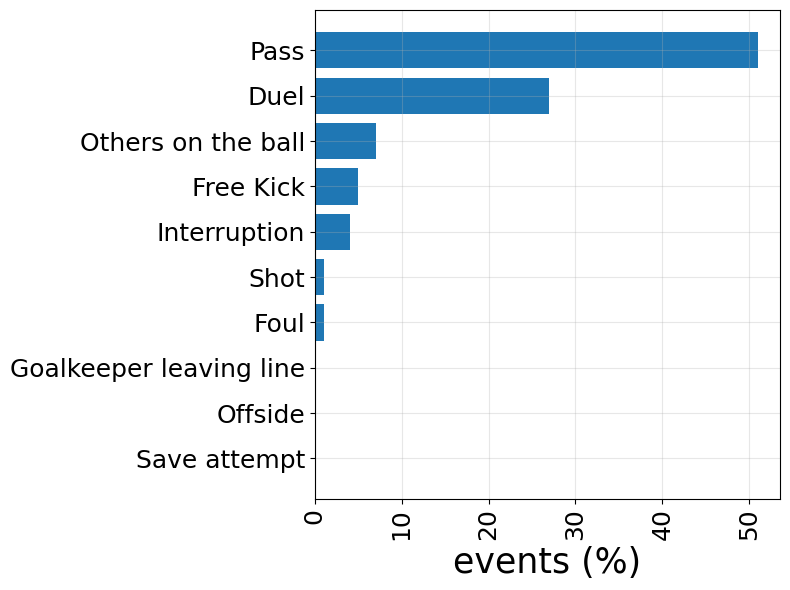

In [41]:
ev_all_nations = []
for nation in nations:
    for i in range(len(events[nation])):
        ev_all_nations.append(events[nation][i]['eventName'])

count = Counter(ev_all_nations)
counter = {}
for i,v in zip(count.keys(),count.values()):
    counter[i] = int(float(v)/len(ev_all_nations)*100)
sorted_d = np.array(sorted(counter.items(), key=operator.itemgetter(1), reverse=False))

#bar plot
f,ax = plt.subplots(figsize=(8,6))
plt.barh(list(sorted_d[:,0]),[int(x) for x in list(sorted_d[:,1])])
plt.xticks(rotation=90)
plt.xticks(fontsize=18)
plt.xlabel('events (%)', fontsize=25)
plt.yticks(fontsize=18)
plt.grid(alpha=0.3)
f.tight_layout()
plt.show()

In [42]:
events_marchisio[0]

{'eventId': 8,
 'subEventName': 'Simple pass',
 'tags': [{'id': 1801}],
 'playerId': 20470,
 'positions': [{'y': 65, 'x': 22}, {'y': 3, 'x': 35}],
 'matchId': 2575964,
 'eventName': 'Pass',
 'teamId': 3159,
 'matchPeriod': '1H',
 'eventSec': 279.842312,
 'subEventId': 85,
 'id': 180114114}

In [43]:
events_marchisio[4]

{'eventId': 1,
 'subEventName': 'Ground defending duel',
 'tags': [{'id': 503}, {'id': 1601}, {'id': 701}, {'id': 1802}],
 'playerId': 20470,
 'positions': [{'y': 74, 'x': 64}, {'y': 76, 'x': 67}],
 'matchId': 2575964,
 'eventName': 'Duel',
 'teamId': 3159,
 'matchPeriod': '1H',
 'eventSec': 567.892892,
 'subEventId': 12,
 'id': 180114250}

In [44]:
len(events_marchisio)

114

In [45]:
sorted_list_marchisio = sorted(events_marchisio, key=lambda x: x['eventSec'])

In [46]:
for event in sorted_list_marchisio:
    print(event['eventName'], event['eventSec'])

Pass 80.99858300000005
Pass 80.99858300000005
Duel 219.95824200000015
Duel 219.95824200000015
Duel 230.25882199999978
Duel 230.25882199999978
Pass 279.842312
Pass 279.842312
Pass 331.37735699999996
Pass 331.37735699999996
Pass 347.58480199999985
Pass 347.58480199999985
Pass 348.01793
Pass 348.01793
Pass 394.2922440000002
Pass 394.2922440000002
Pass 402.66041800000005
Pass 402.66041800000005
Pass 411.5169999999998
Pass 411.5169999999998
Pass 434.52019900000005
Pass 434.52019900000005
Duel 567.892892
Duel 567.892892
Pass 588.093021
Pass 588.093021
Pass 675.4793569999999
Pass 675.4793569999999
Pass 681.340938
Pass 681.340938
Pass 682.4896039999999
Pass 682.4896039999999
Pass 721.556634
Pass 721.556634
Pass 777.2274420000001
Pass 777.2274420000001
Duel 861.7720509999999
Duel 861.7720509999999
Duel 894.6580710000001
Duel 894.6580710000001
Pass 925.6586580000001
Pass 925.6586580000001
Pass 967.288215
Pass 967.288215
Pass 1036.519273
Pass 1036.519273
Pass 1043.416275
Pass 1043.416275
Pass 109

In [47]:
2630/60

43.833333333333336

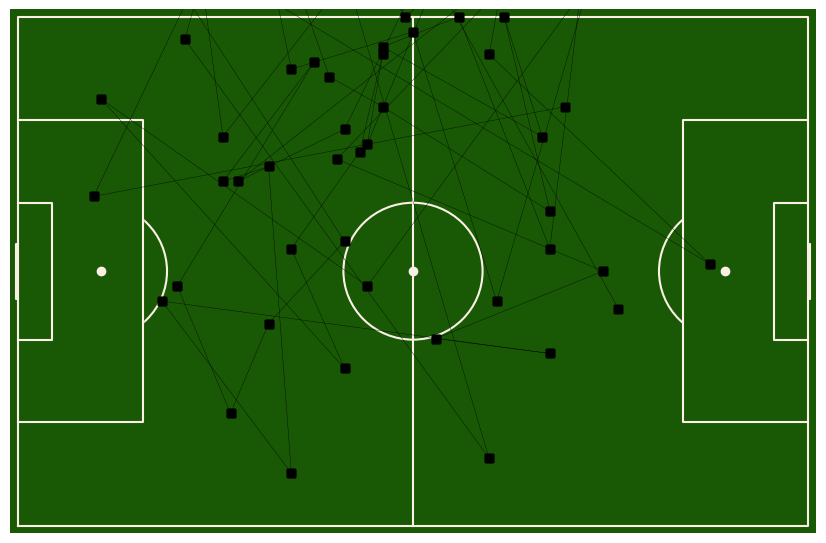

In [48]:
#draws edges between consecutive events
f = draw_pitch("#195905", "#faf0e6", "h", "full")
for i in range(len(sorted_list_marchisio)-1):
    x1, y1 = [sorted_list_marchisio[i]['positions'][0]['x'], sorted_list_marchisio[i+1]['positions'][0]['x']], [sorted_list_marchisio[i]['positions'][0]['y'], sorted_list_marchisio[i+1]['positions'][0]['y']]
    plt.plot(x1, y1, marker = 's', c='k', linewidth=0.25, zorder=12)

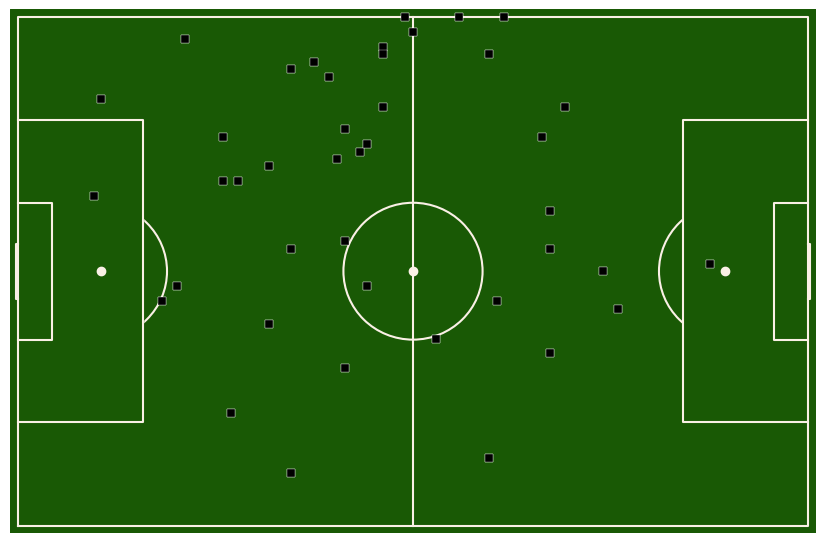

In [49]:
f = draw_pitch("#195905", "#faf0e6", "h", "full")
for event in events_marchisio:
    plt.scatter(event['positions'][0]['x'], event['positions'][0]['y'], marker='s', c='k', edgecolors="w", linewidth=0.25, zorder=12)

In [50]:
napoli_matches = []

In [51]:
for match in matches['Italy']:
    if '3187' in list(match['teamsData']):
        napoli_matches.append(match)
    

In [52]:
len(napoli_matches)

38

In [53]:
napoli_matches[0]['wyId']

2575962

In [54]:
for player in players:
    if(player['wyId'] == 99452):
        print(player)

{'passportArea': {'name': 'Poland', 'id': '616', 'alpha3code': 'POL', 'alpha2code': 'PL'}, 'weight': 78, 'firstName': 'Arkadiusz', 'middleName': '', 'lastName': 'Milik', 'currentTeamId': 3187, 'birthDate': '1994-02-28', 'height': 186, 'role': {'code2': 'FW', 'code3': 'FWD', 'name': 'Forward'}, 'birthArea': {'name': 'Poland', 'id': '616', 'alpha3code': 'POL', 'alpha2code': 'PL'}, 'wyId': 99452, 'foot': 'left', 'shortName': 'A. Milik', 'currentNationalTeamId': 13869}


In [55]:
milik_events = []

In [56]:
for event in events['Italy']:
    if(event['playerId'] == 99452 and event['matchId'] == 2575962):
        milik_events.append(event)

In [57]:
milik_events

[{'eventId': 8,
  'subEventName': 'Simple pass',
  'tags': [{'id': 1801}],
  'playerId': 99452,
  'positions': [{'y': 51, 'x': 50}, {'y': 50, 'x': 40}],
  'matchId': 2575962,
  'eventName': 'Pass',
  'teamId': 3187,
  'matchPeriod': '1H',
  'eventSec': 2.5496499999999855,
  'subEventId': 85,
  'id': 180075012},
 {'eventId': 1,
  'subEventName': 'Ground attacking duel',
  'tags': [{'id': 703}, {'id': 1801}],
  'playerId': 99452,
  'positions': [{'y': 31, 'x': 83}, {'y': 9, 'x': 94}],
  'matchId': 2575962,
  'eventName': 'Duel',
  'teamId': 3187,
  'matchPeriod': '1H',
  'eventSec': 78.505131,
  'subEventId': 11,
  'id': 180075040},
 {'eventId': 1,
  'subEventName': 'Ground attacking duel',
  'tags': [{'id': 701}, {'id': 1802}],
  'playerId': 99452,
  'positions': [{'y': 9, 'x': 94}, {'y': 6, 'x': 85}],
  'matchId': 2575962,
  'eventName': 'Duel',
  'teamId': 3187,
  'matchPeriod': '1H',
  'eventSec': 82.942385,
  'subEventId': 11,
  'id': 180075042},
 {'eventId': 8,
  'subEventName': 'S

In [58]:
sorted_list_milik = sorted(milik_events, key=lambda x: x['eventSec'])

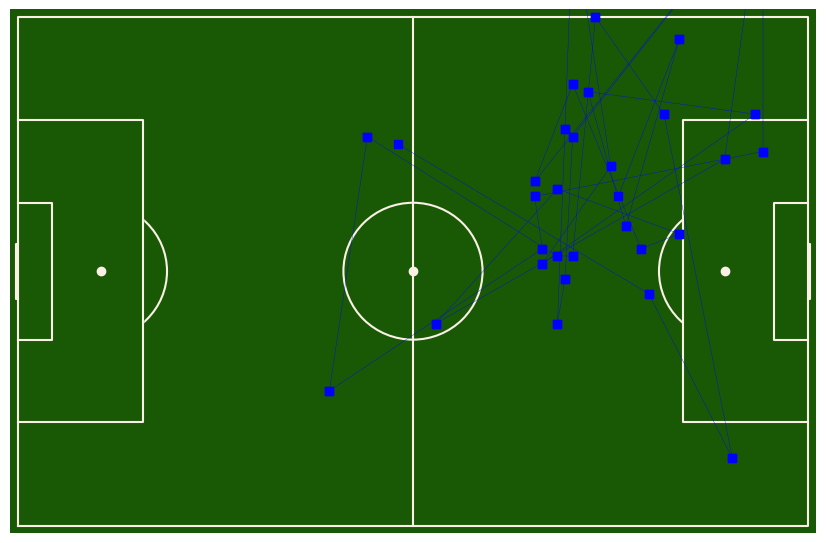

In [59]:
#draws edges between consecutive events
f = draw_pitch("#195905", "#faf0e6", "h", "full")
for i in range(len(sorted_list_milik)-1):
    x1, y1 = [sorted_list_milik[i]['positions'][0]['x'], sorted_list_milik[i+1]['positions'][0]['x']], [sorted_list_milik[i]['positions'][0]['y'], sorted_list_milik[i+1]['positions'][0]['y']]
    plt.plot(x1, y1, marker = 's', c='b', linewidth=0.25, zorder=12)